In [1]:
import numpy as np
import pandas as pd

In [2]:
class DeepClassifier():
    def __init__ (self,model_arch,no_examples,lambd):
        self.in_size = model_arch[0]
        self.out_size = model_arch[-1]
        DeepClassifier.m = no_examples
        self.hidden = model_arch[1:-1]
        param = {}
        DeepClassifier.model_arch = model_arch
        DeepClassifier.lambd = lambd
        
        for l in range(1, len(model_arch)):
            param['W' + str(l)] = np.random.randn(DeepClassifier.model_arch[l], DeepClassifier.model_arch[l-1])*np.sqrt(2 / DeepClassifier.model_arch[l - 1]) 
            param['b' + str(l)] = np.zeros((DeepClassifier.model_arch[l], 1))
        DeepClassifier.param = param
        DeepClassifier.losslist = []

    def linear_forward(A,w,b):
        z = np.dot(w,A) + b
        cache = (A,w,b)
        return z,cache
    
    def sigmoid(z):
        A = 1/(1+np.exp(-z))
        cache = z
        return A,cache
    
    def relu(z):
        A = np.maximum(0,z)
        cache = z
        return A,cache
        
    def linear_activation_forward(A_prev,w,b,activation):
        
        if activation == "sigmoid":
            Z,linear_cache  = DeepClassifier.linear_forward(A_prev,w,b)
            A,activation_cache  = DeepClassifier.sigmoid(Z)
            
        elif activation == "relu":
                Z, linear_cache = DeepClassifier.linear_forward(A_prev,w,b)
                A, activation_cache = DeepClassifier.relu(Z)

        cache = (linear_cache, activation_cache)
        return A, cache
    
    def L_model_forward(x,param):
        caches = []
        A = x
        
        for l in range(1,len(DeepClassifier.model_arch)-1):
            A_prev = A
            A, cache = DeepClassifier.linear_activation_forward(A_prev,DeepClassifier.param['W' + str(l)],DeepClassifier.param['b' + str(l)], activation = "relu")            
            caches.append(cache)
   
        AL, cache = DeepClassifier.linear_activation_forward(A, DeepClassifier.param['W' + str(len(DeepClassifier.model_arch)-1)], DeepClassifier.param['b' + str(len(DeepClassifier.model_arch)-1)], activation = "sigmoid")
        caches.append(cache)

        return AL, caches

    def compute_cost(AL, Y):
        
        cost = -1./DeepClassifier.m * np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL))
        cost = np.squeeze(cost)

        return cost

    def linear_backward(dZ, cache):
        A_prev, W, b = cache
        
        dW = 1./DeepClassifier.m * np.dot(dZ, A_prev.T)
        db = 1./DeepClassifier.m * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)

        return dA_prev, dW, db


    def sigmoid_backward(dA, cache):
   
        Z = cache 
        s = 1/(1+np.exp(-Z))
        dZ = dA * s * (1-s)
        
        return dZ

    def relu_backward(dA, cache):
    
        Z = cache
        dZ = np.array(dA, copy=True)  
        dZ[Z <= 0] = 0
        
        return dZ
    
    
    def linear_activation_backward(dA, cache, activation):
        linear_cache, activation_cache = cache
    
        if activation == "relu":
            dZ = DeepClassifier.relu_backward(dA, activation_cache)
            dA_prev, dW, db = DeepClassifier.linear_backward(dZ, linear_cache)

        elif activation == "sigmoid":
            dZ = DeepClassifier.sigmoid_backward(dA, activation_cache)
            dA_prev, dW, db = DeepClassifier.linear_backward(dZ, linear_cache)

        return dA_prev, dW, db
    
    def L_model_backward(AL, Y, caches):
        grads = {}
        
        L = len(DeepClassifier.model_arch)-1
        
        
        Y = Y.reshape(AL.shape)

        
        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

        current_cache = caches[L-1]
        grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = DeepClassifier.linear_activation_backward(dAL, current_cache, "sigmoid")
       
        for l in reversed(range(L-1)):
            
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = DeepClassifier.linear_activation_backward(grads["dA"+str(l+1)], current_cache, "relu")
            grads["dA" + str(l)] = dA_prev_temp
            grads["dW" + str(l + 1)] = dW_temp + (DeepClassifier.lambd *DeepClassifier.param["W" + str(l+1)] ) /DeepClassifier.m
            grads["db" + str(l + 1)] = db_temp
        
        return grads

    def update_parameters(param, grads, learning_rate):
    
        L = len(DeepClassifier.model_arch)-1 
        
        for l in range(L):
            DeepClassifier.param["W" + str(l+1)] = DeepClassifier.param["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
            DeepClassifier.param["b" + str(l+1)] = DeepClassifier.param["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]
        return param


    def fit(self,x_train,y_train,epochs,learning_rate):
        
        for epoch in range(epochs):
                AL,caches = DeepClassifier.L_model_forward(x_train,DeepClassifier.param)
                cost = DeepClassifier.compute_cost(AL, y_train)
                self.losslist.append(cost)
                if epoch % 1000 == 0:
                    print(f"loss is {cost} in {epoch}th epoch ")
                grads = DeepClassifier.L_model_backward(AL, y_train, caches)
                self.param = DeepClassifier.update_parameters(DeepClassifier.param, grads, learning_rate)
                    

    def predict(self,x):
        A = x
        for l in range(1,len(DeepClassifier.model_arch)-1):
            A_prev = A
            A, cache = DeepClassifier.linear_activation_forward(A_prev,DeepClassifier.param['W' + str(l)],DeepClassifier.param['b' + str(l)], activation = "relu")            
            
        AL, cache = DeepClassifier.linear_activation_forward(A, DeepClassifier.param['W' + str(len(DeepClassifier.model_arch)-1)], DeepClassifier.param['b' + str(len(DeepClassifier.model_arch)-1)], activation = "sigmoid")
        

        return AL

In [3]:
import pandas as pd

In [4]:
data = pd.read_csv("P:/tech/datasets/titanic_prep.csv")

In [5]:
x = data.drop(["Survived","Unnamed: 0"],axis = 1).values
y = data["Survived"].values

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
scaler = StandardScaler()

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25)

In [10]:
x_train_sc = scaler.fit_transform(x_train)
x_test_sc = scaler.transform(x_test)

In [11]:
cls = DeepClassifier(model_arch=[8,7,5,3,1],no_examples=x_train.shape[0],lambd=0.1)

In [12]:
cls.fit(x_train_sc.T,y_train.reshape(1,-1),epochs = 20000,learning_rate= 0.4)

loss is 1.2914731080173714 in 0th epoch 
loss is 0.40672602678488257 in 1000th epoch 
loss is 0.40069411086836404 in 2000th epoch 
loss is 0.3962454599339615 in 3000th epoch 
loss is 0.39120194283032017 in 4000th epoch 
loss is 0.3890115328743963 in 5000th epoch 
loss is 0.3866333111590877 in 6000th epoch 
loss is 0.38333678413398586 in 7000th epoch 
loss is 0.374807455806574 in 8000th epoch 
loss is 0.35602627773291756 in 9000th epoch 
loss is 0.36390333248301804 in 10000th epoch 
loss is 0.3658748778942003 in 11000th epoch 
loss is 0.3549280202307234 in 12000th epoch 
loss is 0.36173379337231526 in 13000th epoch 
loss is 0.36178408009682894 in 14000th epoch 
loss is 0.3596619775714164 in 15000th epoch 
loss is 0.35336057865285997 in 16000th epoch 
loss is 0.3764724659733736 in 17000th epoch 
loss is 0.3677497004330544 in 18000th epoch 
loss is 0.3541436502253335 in 19000th epoch 


In [13]:
x_train_sc.shape

(668, 8)

In [14]:
y_pred = cls.predict(x_test_sc.T)

In [15]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0

In [16]:
from sklearn.metrics import confusion_matrix,accuracy_score
print(confusion_matrix(y_pred.reshape(-1),y_test))
accuracy_score(y_test,y_pred.reshape(-1))

[[130  21]
 [ 11  61]]


0.8565022421524664

In [18]:
import matplotlib.pyplot as plt

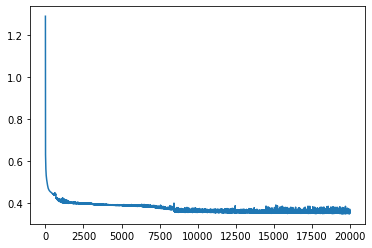

In [19]:
plt.plot(cls.losslist)